# Sources
- https://medium.com/thedeephub/cleaning-llm-generated-knowledge-graphs-to-improve-data-quality-2b5caa1ae4dc
- https://bratanic-tomaz.medium.com/constructing-knowledge-graphs-from-text-using-openai-functions-096a6d010c17
- https://www.datacamp.com/tutorial/knowledge-graph-rag
- https://python.langchain.com/docs/integrations/llms/huggingface_endpoint/
- https://huggingface.co/blog/open-source-llms-as-agents
- https://python.langchain.com/v0.1/docs/use_cases/graph/constructing/

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Prompt
I want to build a knowledge graph from articles related to "Haryy Potter" in Wikipedia. And not just from one single doucment. I may need also some chunking strategies like RecursiveCharacterTextSplitter and CharacterTextSplitter, before passing the documents to my llm.
Can you please tell me how should I change the code?

In [2]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=358e653aa56f0f1944c7560e795e8c5fc6b61e68f34caa74de843340a2a4c1cf
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [3]:
!pip install langchain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.4/404.4 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
  Attempting uninstall: requests-toolbelt
    Found existing installation: requests-toolbelt 0.10.1
    Uninstalling requests-toolbelt-0.10.1:
      Successfully uninstalled requests-toolbelt-0.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.3 requires cubinlinker, which is not installed.
cudf 24.8.3 

In [4]:
!pip install -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 35.0 MB/s eta 0:00:00a 0:00:01


In [5]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.5 MB/s eta 0:00:0000:01


In [6]:
import wikipedia
from tqdm import tqdm

In [7]:
from langchain.document_loaders import WikipediaLoader
from langchain.text_splitter import CharacterTextSplitter

In [8]:
raw_documents = WikipediaLoader(query="Harry Potter").load()

# Define chunking strategy
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=20
)
# Chunk the document
documents = text_splitter.split_documents(raw_documents)
for d in tqdm(documents):
    del d.metadata["summary"]

100%|██████████| 25/25 [00:00<00:00, 225016.31it/s]


In [9]:
for doc in documents:
    print(doc.metadata['source'])

https://en.wikipedia.org/wiki/Harry_Potter
https://en.wikipedia.org/wiki/Harry_Potter_(film_series)
https://en.wikipedia.org/wiki/Harry_Potter_and_the_Philosopher%27s_Stone
https://en.wikipedia.org/wiki/Harry_Potter_and_the_Philosopher%27s_Stone_(film)
https://en.wikipedia.org/wiki/Harry_Potter_and_the_Cursed_Child
https://en.wikipedia.org/wiki/List_of_Harry_Potter_characters
https://en.wikipedia.org/wiki/Harry_Potter_(character)
https://en.wikipedia.org/wiki/Harry_Potter_and_the_Deathly_Hallows_%E2%80%93_Part_1
https://en.wikipedia.org/wiki/Harry_Potter_and_the_Deathly_Hallows_%E2%80%93_Part_2
https://en.wikipedia.org/wiki/Harry_Potter_and_the_Order_of_the_Phoenix_(film)
https://en.wikipedia.org/wiki/Harry_Potter_and_the_Half-Blood_Prince_(film)
https://en.wikipedia.org/wiki/Harry_Potter_and_the_Deathly_Hallows
https://en.wikipedia.org/wiki/Harry_Potter_and_the_Goblet_of_Fire_(film)
https://en.wikipedia.org/wiki/Magic_in_Harry_Potter
https://en.wikipedia.org/wiki/Harry_Potter_and_the_

In [10]:
# Step 1: Use a set to track seen sources
unique_documents = []
seen_sources = set()

# Step 2: Iterate through the documents and store only unique sources
for doc in documents:
    source = doc.metadata['source']
    if source not in seen_sources:
        unique_documents.append(doc)
        seen_sources.add(source)

# Step 3: Iterate through unique documents and print their sources
for doc in unique_documents:
    print(doc.metadata['source'])

https://en.wikipedia.org/wiki/Harry_Potter
https://en.wikipedia.org/wiki/Harry_Potter_(film_series)
https://en.wikipedia.org/wiki/Harry_Potter_and_the_Philosopher%27s_Stone
https://en.wikipedia.org/wiki/Harry_Potter_and_the_Philosopher%27s_Stone_(film)
https://en.wikipedia.org/wiki/Harry_Potter_and_the_Cursed_Child
https://en.wikipedia.org/wiki/List_of_Harry_Potter_characters
https://en.wikipedia.org/wiki/Harry_Potter_(character)
https://en.wikipedia.org/wiki/Harry_Potter_and_the_Deathly_Hallows_%E2%80%93_Part_1
https://en.wikipedia.org/wiki/Harry_Potter_and_the_Deathly_Hallows_%E2%80%93_Part_2
https://en.wikipedia.org/wiki/Harry_Potter_and_the_Order_of_the_Phoenix_(film)
https://en.wikipedia.org/wiki/Harry_Potter_and_the_Half-Blood_Prince_(film)
https://en.wikipedia.org/wiki/Harry_Potter_and_the_Deathly_Hallows
https://en.wikipedia.org/wiki/Harry_Potter_and_the_Goblet_of_Fire_(film)
https://en.wikipedia.org/wiki/Magic_in_Harry_Potter
https://en.wikipedia.org/wiki/Harry_Potter_and_the_

In [12]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [13]:
# Define the text splitter with chunking strategy
rec_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=20,
    separators=["\n\n", "\n"]
)

In [14]:
chunks = rec_text_splitter.split_documents(unique_documents)

In [16]:
len(chunks)

239

In [15]:
chunks[1]

Document(metadata={'title': 'Harry Potter', 'source': 'https://en.wikipedia.org/wiki/Harry_Potter'}, page_content='\nThe series was originally published in English by Bloomsbury in the United Kingdom and Scholastic Press in the United States.  A series of many genres, including fantasy, drama, coming-of-age fiction, and the British school story (which includes elements of mystery, thriller, adventure, horror, and romance), the world of Harry Potter explores numerous themes and includes many cultural meanings and references. Major themes in the series include prejudice, corruption, madness, love, and death.')

In [17]:
!pip install matplotlib seaborn

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


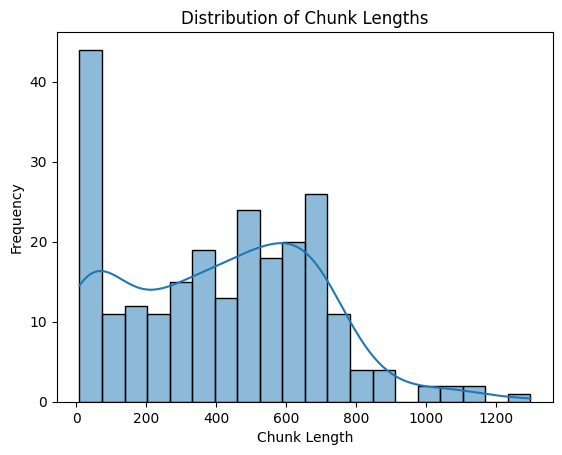

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

chunk_lengths = [len(doc.page_content) for doc in chunks]

sns.histplot(chunk_lengths, bins=20, kde=True)

plt.title('Distribution of Chunk Lengths')
plt.xlabel('Chunk Length')
plt.ylabel('Frequency')

plt.show()

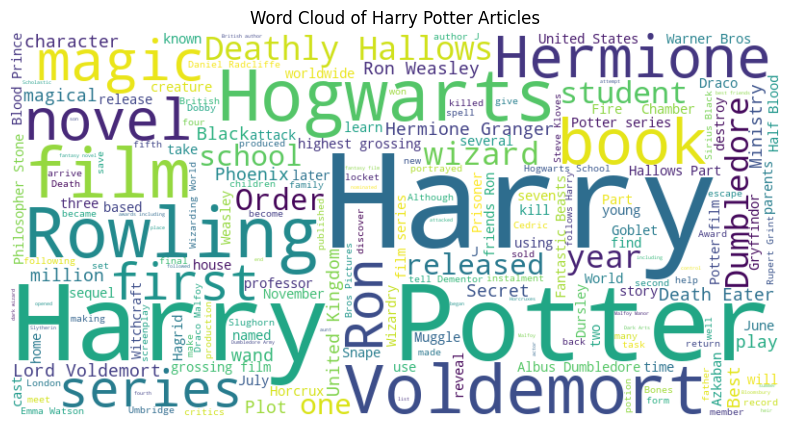

In [19]:
from wordcloud import WordCloud

all_text = " ".join([doc.page_content for doc in chunks])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Harry Potter Articles')
plt.show()


In [20]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [21]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [28]:
# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [29]:
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove punctuation and special characters
    text = re.sub(r'\W', ' ', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

In [25]:
from langchain_core.documents import Document

In [30]:
# Apply preprocessing to each document
preprocessed_documents = [
    Document(page_content=preprocess_text(doc.page_content), metadata=doc.metadata)
    for doc in tqdm(chunks, desc="Preprocessing Documents")
]



Preprocessing Documents:   0%|          | 0/239 [03:53<?, ?it/s]


Preprocessing Documents:   0%|          | 1/239 [00:02<08:38,  2.18s/it]

Preprocessing Documents:  43%|████▎     | 102/239 [00:02<00:02, 62.57it/s]

Preprocessing Documents: 100%|██████████| 239/239 [00:02<00:00, 99.09it/s] 


In [31]:
type(preprocessed_documents)

list

In [32]:
preprocessed_documents[1]

Document(metadata={'title': 'Harry Potter', 'source': 'https://en.wikipedia.org/wiki/Harry_Potter'}, page_content='series originally published english bloomsbury united kingdom scholastic press united state series many genre including fantasy drama coming age fiction british school story includes element mystery thriller adventure horror romance world harry potter explores numerous theme includes many cultural meaning reference major theme series include prejudice corruption madness love death')

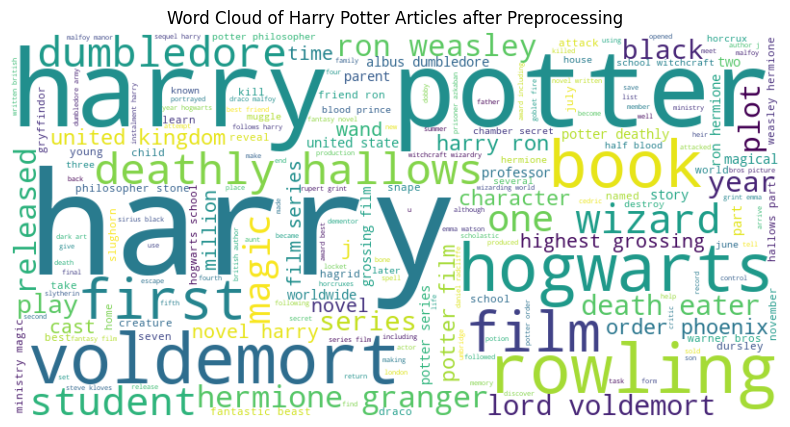

In [33]:
all_text = " ".join([doc.page_content for doc in preprocessed_documents])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Harry Potter Articles after Preprocessing')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


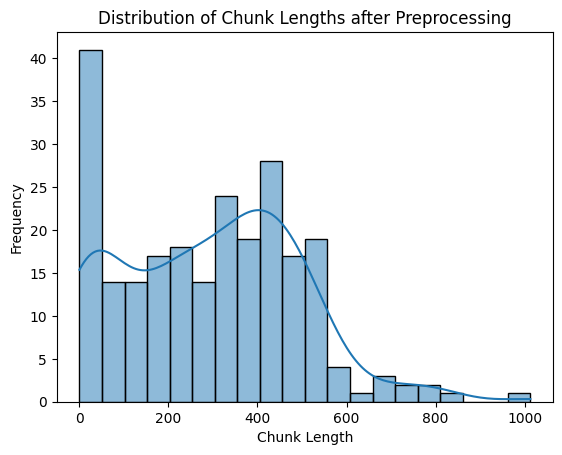

In [34]:
chunk_lengths = [len(doc.page_content) for doc in preprocessed_documents]

sns.histplot(chunk_lengths, bins=20, kde=True)

plt.title('Distribution of Chunk Lengths after Preprocessing')
plt.xlabel('Chunk Length')
plt.ylabel('Frequency')

plt.show()

In [11]:
!pip install --upgrade --quiet  langchain langchain-community langchain-openai langchain-experimental neo4j

In [36]:
import os
from getpass import getpass

from langchain_community.graphs import Neo4jGraph

neo4j_url = getpass()
neo4j_user = getpass()
neo4j_password = getpass()

graph = Neo4jGraph(neo4j_url, neo4j_user, neo4j_password)

In [37]:
graph.refresh_schema()
print(graph.schema)

Node properties:

Relationship properties:

The relationships:



In [38]:
!pip install --upgrade --quiet huggingface_hub

In [41]:
!pip install langchain-huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 11.5 MB/s eta 0:00:00


In [39]:

HUGGINGFACEHUB_API_TOKEN = getpass()

 ·····································


In [42]:
from langchain_huggingface import HuggingFaceEndpoint
from langchain.chains import LLMChain
from langchain_core.prompts import PromptTemplate

In [44]:
from langchain_experimental.graph_transformers import LLMGraphTransformer

In [46]:
!pip install json-repair

In [91]:
repo_id = "mistralai/Mistral-7B-Instruct-v0.2"

llm = HuggingFaceEndpoint(
    repo_id=repo_id,
    max_length=10000,
    temperature=0.001,
    huggingfacehub_api_token=HUGGINGFACEHUB_API_TOKEN,
)

llm_transformer = LLMGraphTransformer(llm=llm)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [94]:
llm = HuggingFaceEndpoint(
    repo_id="HuggingFaceH4/zephyr-7b-beta",
    temperature=0.001,
    huggingfacehub_api_token=HUGGINGFACEHUB_API_TOKEN
)
llm_transformer = LLMGraphTransformer(llm=llm)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
documents

In [72]:
# Concatenate all document contents into a single string
all_text = " ".join([doc.page_content for doc in chunks])

# Create a single Document object
# combined_document = Document(page_content=all_text)

In [60]:
type(combined_document)

langchain_core.documents.base.Document

In [63]:
len(combined_document.page_content)

70060

In [73]:
len(all_text)

98385

In [92]:
text = """
Geoffrey Hinton, often referred to as the "godfather of AI," is a British-Canadian cognitive psychologist and computer scientist renowned for his pioneering work in artificial intelligence and neural networks. Born on December 6, 1947, in London, England, Hinton has significantly influenced the field of AI through his research and innovations. He is particularly known for developing backpropagation, a key algorithm that allows neural networks to learn from data.
Hinton studied at the University of Cambridge, where he earned his PhD in artificial intelligence, and later became a professor at the University of Toronto. His work at the University of Toronto laid the foundation for deep learning, a subset of machine learning.
Yann LeCun, a French computer scientist and another prominent figure in AI, collaborated with Hinton on several projects. LeCun, currently the Chief AI Scientist at Meta (formerly Facebook), is known for his work on convolutional neural networks (CNNs), which are used extensively in computer vision.
In 2020, Hinton, LeCun, and Yoshua Bengio were awarded the Turing Award, often called the "Nobel Prize of Computing," for their contributions to deep learning. Bengio, a Canadian computer scientist, is a professor at the University of Montreal and a co-founder of the AI company Element AI.
In 2023, Geoffrey Hinton resigned from his position at Google, where he had worked since 2013, to express concerns about the risks posed by unchecked AI development. Hinton warned that AI could pose existential risks if it continues to evolve without sufficient regulation.
In 2024, Hinton's contributions to AI were recognized with the Nobel Prize in Physics, which he shared with John Hopfield of Princeton University for their groundbreaking work in neural networks.
In 2022, LeCun and Bengio founded the International AI Research Institute, aiming to advance ethical AI research. They were joined by Fei-Fei Li, a Chinese-American computer scientist known for her work in computer vision and as a former director of the Stanford Artificial Intelligence Laboratory (SAIL).
In addition to their individual research, all three AI pioneers have been vocal about the ethical implications of AI. LeCun and Bengio have advocated for transparent AI development practices, while Hinton has called for stricter regulation. Fei-Fei Li, known for advocating diversity in AI research, has worked with various international organizations to ensure that AI benefits all of humanity.
"""


In [93]:
documents = [Document(page_content=text)]

llm_transformer_filtered = LLMGraphTransformer(
    llm=llm,  
    allowed_nodes=["Person", "Country", "Organization", "Award", "Event", "Location", "Date"],
    allowed_relationships=[
        "NATIONALITY", "LOCATED_IN", "WORKED_AT", "ACHIEVED", "STUDIED_AT", 
        "FOUNDED", "BORN_IN", "COLLABORATED_WITH", "AWARDED"
    ]
)

graph_documents_filtered = llm_transformer_filtered.convert_to_graph_documents(documents)

print(f"Nodes: {graph_documents_filtered[0].nodes}")
print(f"Relationships: {graph_documents_filtered[0].relationships}")

Nodes: [Node(id='International AI Research Institute', type='Organization', properties={}), Node(id='Yann LeCun', type='Person', properties={}), Node(id='Turing Award', type='Award', properties={}), Node(id='Geoffrey Hinton', type='Person', properties={}), Node(id='London, England', type='Location', properties={}), Node(id='Nobel Prize in Physics', type='Award', properties={})]
Relationships: [Relationship(source=Node(id='Geoffrey Hinton', type='Person', properties={}), target=Node(id='London, England', type='Location', properties={}), type='BORN_IN', properties={}), Relationship(source=Node(id='Geoffrey Hinton', type='Person', properties={}), target=Node(id='Yann LeCun', type='Person', properties={}), type='COLLABORATED_WITH', properties={}), Relationship(source=Node(id='Geoffrey Hinton', type='Person', properties={}), target=Node(id='Turing Award', type='Award', properties={}), type='AWARDED', properties={}), Relationship(source=Node(id='Geoffrey Hinton', type='Person', properties={}

In [89]:
graph.add_graph_documents(graph_documents_filtered)

In [90]:
graph.refresh_schema()
print(graph.schema)

Node properties:
Organization {id: STRING}
Person {id: STRING}
Award {id: STRING}
Location {id: STRING}
Relationship properties:

The relationships:
(:Person)-[:COLLABORATED_WITH]->(:Person)
(:Person)-[:FOUNDED]->(:Organization)
(:Person)-[:BORN_IN]->(:Location)
(:Person)-[:AWARDED]->(:Award)


## HuggingFaceH4/zephyr-7b-bet

In [95]:
llm_transformer_filtered = LLMGraphTransformer(
    llm=llm,  
    allowed_nodes=["Person", "Country", "Organization", "Award", "Event", "Location", "Date"],
    allowed_relationships=[
        "NATIONALITY", "LOCATED_IN", "WORKED_AT", "ACHIEVED", "STUDIED_AT", 
        "FOUNDED", "BORN_IN", "COLLABORATED_WITH", "AWARDED"
    ]
)

graph_documents_filtered = llm_transformer_filtered.convert_to_graph_documents(documents)

print(f"Nodes: {graph_documents_filtered[0].nodes}")
print(f"Relationships: {graph_documents_filtered[0].relationships}")

Nodes: []
Relationships: []
